In [1]:
import tensorflow as tf
import os
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import matplotlib.pyplot as plt
print(tf.__version__)

2022-04-17 20:39:03.800995: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


In [2]:
print(len(tf.config.list_physical_devices('GPU')))
!clear

1


2022-04-17 20:39:06.138399: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-17 20:39:06.178115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 20:39:06.178729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-04-17 20:39:06.178802: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-17 20:39:06.189376: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-17 20:39:06.189495: I tensorflow/stream_executor/platform/de

In [3]:
# Parameters
IMAGE_WIDTH = 32 
IMAGE_HEIGHT = 32
BATCH_SIZE = 16
n_classes = 34

train_dir = 'classification_dataset/train/'
val_dir = 'classification_dataset/val/'
test_dir = 'classification_dataset/test/'

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,     #Random rotation between 0 and 45
    width_shift_range=0.2,   #% shift
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
)

valgen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

testgen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = datagen.flow_from_directory(
    train_dir,
    shuffle=True,
    batch_size = BATCH_SIZE,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH)
)

valid_generator = valgen.flow_from_directory(
    val_dir,
    shuffle=True,
    batch_size = BATCH_SIZE,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH)
)

test_generator = testgen.flow_from_directory(
    test_dir,
    shuffle=True,
    batch_size = BATCH_SIZE,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
)

Found 187686 images belonging to 34 classes.
Found 50702 images belonging to 34 classes.
Found 66119 images belonging to 34 classes.


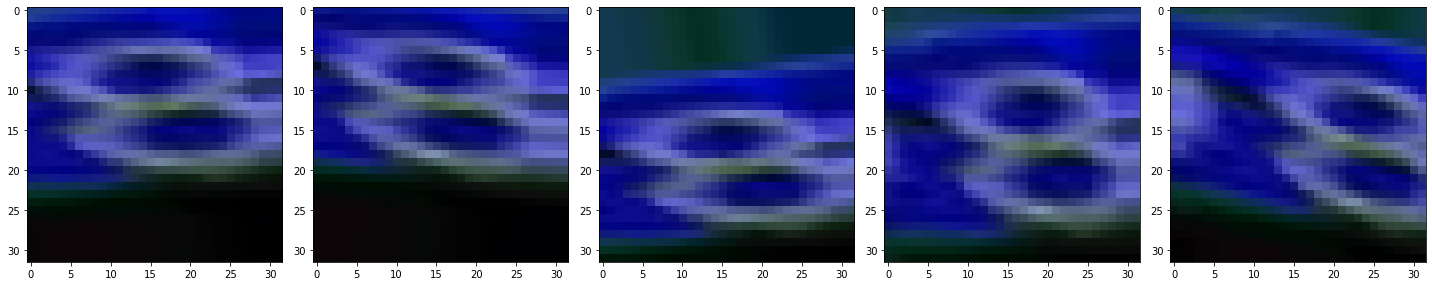

In [4]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [6]:
# def build_model(num_classes):
#     model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', 
#                            input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
#     tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
#     tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])
#     return model
# model = build_model(num_classes=n_classes)

In [7]:
from    tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

def VGG16(nb_classes, input_shape):
    input_tensor = Input(shape=input_shape)
    # 1st block
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='conv1a')(input_tensor)
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='conv1b')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'pool1')(x)
    # 2nd block
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='conv2a')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='conv2b')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'pool2')(x)
    # 3rd block
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='conv3a')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='conv3b')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='conv3c')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'pool3')(x)
    # 4th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv4a')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv4b')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv4c')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'pool4')(x)
    # 5th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv5a')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv5b')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv5c')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'pool5')(x)
    # full connection
    x = Flatten()(x)
    x = Dense(4096, activation='relu',  name='fc6')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc7')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(nb_classes, activation='softmax', name='fc8')(x)

    model = Model(input_tensor, output_tensor)
    return model

model=VGG16(n_classes, (IMAGE_HEIGHT, IMAGE_WIDTH, 3))

2022-04-01 20:57:53.633209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 20:57:53.633702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 20:57:53.634007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-04-01 20:57:53.634120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but the

In [8]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

EPOCHS = 20

with tf.device('/GPU:0'):
    history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    validation_steps= valid_generator.samples // BATCH_SIZE,
                    verbose=1
                    )


/home/mihai/TFG/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-04-01 20:57:55.262340: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-01 20:57:55.281860: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2799925000 Hz


Epoch 1/50


2022-04-01 20:57:56.129848: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-04-01 20:57:56.840173: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2022-04-01 20:57:57.723669: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-01 20:57:58.387203: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


11730/11730 [==============================] - 950s 81ms/step - loss: 1.9935 - accuracy: 0.3938 - val_loss: 0.5547 - val_accuracy: 0.8294
Epoch 2/50
11730/11730 [==============================] - 897s 76ms/step - loss: 0.6890 - accuracy: 0.7885 - val_loss: 0.2983 - val_accuracy: 0.9140
Epoch 3/50
11730/11730 [==============================] - 893s 76ms/step - loss: 0.4328 - accuracy: 0.8710 - val_loss: 0.2085 - val_accuracy: 0.9409
Epoch 4/50
11730/11730 [==============================] - 898s 77ms/step - loss: 0.3239 - accuracy: 0.9054 - val_loss: 0.1686 - val_accuracy: 0.9533
Epoch 5/50
11730/11730 [==============================] - 899s 77ms/step - loss: 0.2656 - accuracy: 0.9236 - val_loss: 0.1565 - val_accuracy: 0.9558
Epoch 6/50
11730/11730 [==============================] - 895s 76ms/step - loss: 0.2289 - accuracy: 0.9351 - val_loss: 0.1330 - val_accuracy: 0.9644
Epoch 7/50
11730/11730 [==============================] - 891s 76ms/step - loss: 0.2030 - accuracy: 0.9424 - val_loss

In [9]:
results = model.evaluate(test_generator,batch_size=BATCH_SIZE)

4133/4133 [==============================] - 68s 17ms/step - loss: 0.0647 - accuracy: 0.9851


In [10]:
model.save('model_long2.h5')

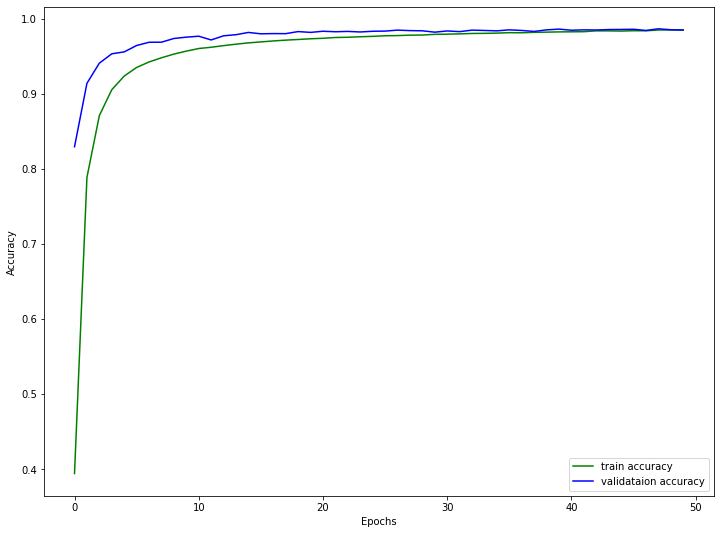

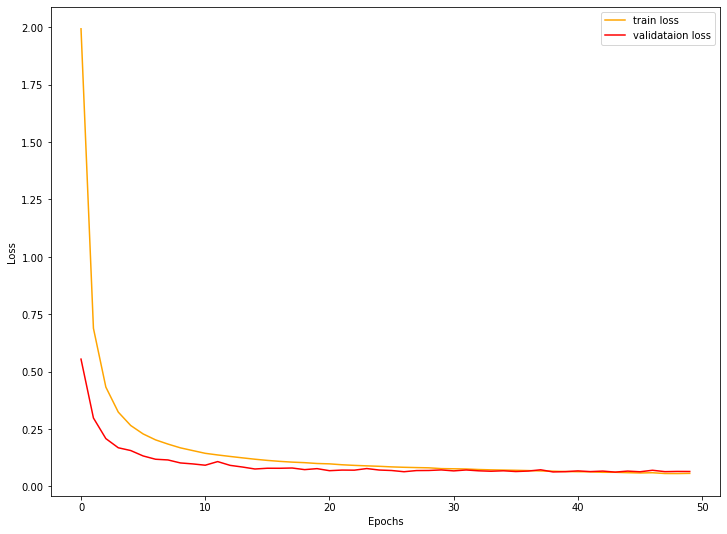

In [11]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(12, 9))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy.png')
    plt.show()
    # loss plots
    plt.figure(figsize=(12, 9))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig('loss.png')
    plt.show()
save_plots(train_acc, valid_acc, train_loss, valid_loss)

In [12]:
import numpy as np
a = np.asarray([train_acc,valid_acc,train_loss,valid_loss])
np.savetxt("model_long_data2.csv", a, delimiter=",")